### Importing libraries

In [20]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation, PillowWriter
from IPython.display import HTML

## Numerical Methods

Since the problems need us to use the same methods many time, first we will create a function that can take in any system of differential equation or equivalently a vector differential equation and numerically compute the solution using the specified methods.

In [21]:
last_method = None
method_params = None
def step(i,t,x,dydt,method,dt):
    global last_method, method_params
    if method=="Euler":
        k1 = dydt(t[i],x[i])*dt
        last_method = method
        return x[i] + k1
    elif method=="RK2":
        k1 = dydt(t[i],x[i])*dt
        k2 = dydt(t[i]+dt,x[i]+k1)*dt
        last_method = method
        return x[i] + (k1+k2)/2
    elif method.startswith("RK2("):
        if method == last_method:
            a1,a2,p,q = method_params
        else:
            params = method[4:-1].strip().split(",")
            ARGS = []
            KWARGS = {"a1":None,"a2":None,"p":None,"q":None}
            for x in params:
                if "=" in x :
                    P,V = x.split("=")
                    KWARGS[P.strip().lower()] = float(V)
                else:
                    ARGS.append(float(x))
            ARGS = ARGS[::-1]
            for x in KWARGS:
                if KWARGS[x] is None:
                    KWARGS[x] = ARGS.pop()
            if KWARGS["a2"] is None: a2 = 1 - a1
            else: a2 = KWARGS["a2"]
            if KWARGS["a1"] is None: a1 = 1 - a2
            else: a1 = KWARGS["a1"]
            if KWARGS["p"] is None: p = 1/(2*a2)
            else: p = KWARGS["p"]
            if KWARGS["q"] is None: q = 1/(2*a2)
            else: q = KWARGS["q"]
            last_method = method
            method_params = (a1,a2,p,q)

        k1 = dydt(t[i],x[i])*dt
        k2 = dydt(t[i]+(p*dt), x[i]+(k1*q*dt))*dt
        return x[i] + (a1*k1 + a2*k2)

    elif method == "EC":
        k1_theta, k1_omega = dydt(t[i], x[i])*dt
        omega_new = x[i][1] + k1_omega
        theta_new = x[i][0] + dt*omega_new
        return (theta_new,omega_new)


def Numerical_Solver(
    x_0, # initial value. Can be a single value or numpy array
    dt,  # Interval \Delat t
    t_ini,t_max, # real values  
    dydt, # a function mapping x,t to the derivative
    methods=["Euler"],
    x_analytical=None, # analytical solution (function). If avaliable, compute errors too
    visualise=False, # if True, does some plotting
    variable_name=None,
    compute_error=True,
    compute_one_step_error=True,
):
    t = np.arange(t_ini, t_max, dt)
    N = t.shape[0] -1 # excluding the start value
    if isinstance(x_0,np.ndarray):
        d = x_0.shape[0] # dimension
    elif isinstance(x_0,list) or isinstance(x_0,tuple):
        d = len(x_0)
        x_0 = np.array(x_0)
    else:d =1
    X = {}
    if x_analytical is not None:
        try: x_analytical = x_analytical(t)
        except:x_analytical = np.array([x_analytical(t_i) for t_i in t])
        X["analytical"] = x_analytical
    for method in methods:
        if d > 1:x = np.zeros((N+1,d))
        else:x = np.zeros(N+1)
        x[0] = x_0
        for i in range(0,N):x[i+1] = step(i,t,x,dydt,method,dt)
        X[method] = x
        if x_analytical is not None:
            if compute_error:
                err = x_analytical -x
                X[method + " error"] = err
            if compute_one_step_error:
                x_one_step = x_analytical.copy() 
                for i in range(0,N):
                    x_one_step[i+1] = step(i,t,x_analytical,dydt,method,dt)
                err_one_step = x_analytical - x_one_step
                # err_one_step = - np.array([0] + [step(i,t,x_analytical,dydt,method,dt) for i in range(0,N)])
                X[method + " one step error"] = err_one_step
    if visualise and d == 1:
        plt.figure()
        for method in methods:
            plt.plot(t, X[method], label=method)
        if x_analytical is not None:
            plt.plot(t, x_analytical, label="analytical")
        plt.xlabel("$t$")
        if variable_name is not None:plt.ylabel(variable_name)
        plt.title("Numerical Solution (" + ",".join(methods) + ")")
        plt.legend()
        if compute_error and (x_analytical is not None):
            plt.figure()
            for method in methods:
                lbl = method + " error"
                plt.plot(t, X[lbl],label=lbl)
            plt.xlabel("$t$")
            plt.ylabel("error")
            plt.legend()
        if compute_one_step_error and (x_analytical is not None):
            plt.figure()
            for method in methods:
                lbl = method + " one step error"
                plt.plot(t, X[lbl],label=lbl)
            plt.xlabel("$t$")
            plt.ylabel("error")
            plt.legend()
        plt.show()
    elif visualise=="PS" and d == 2:
        fig = plt.figure()
        ax = plt.subplot()
        # We look at all methods to find the boundaries
        all_x_min = min([X[m][:,0].min() for m in methods])
        all_y_min = min([X[m][:,1].min() for m in methods])
        all_x_max = max([X[m][:,0].max() for m in methods])
        all_y_max = max([X[m][:,1].max() for m in methods])
        Dx = all_x_max - all_x_min
        Dy = all_y_max - all_y_min
        ax.set_xlim(all_x_min - Dx/10, all_x_max + Dx/10)
        ax.set_ylim(all_y_min - Dy/10, all_y_max + Dy/10)

        LINES = {method : ax.plot([],[],'-',label=method)[0] for method in methods}
        POINTS = {method : ax.plot([],[],'o')[0] for method in methods}
        ax.legend()
        def update(i):
            for method in methods:
                x,y = X[method][:i+1,0],X[method][:i+1,1]
                LINES[method].set_data(x,y)
                POINTS[method].set_data([x[i]],[y[i]])
            return [x for x in LINES.values()] + [x for x in POINTS.values()]
        ani = FuncAnimation(fig, update, frames=len(t), interval=50, blit=False)
        plt.close(fig)
        ani = HTML(ani.to_html5_video())
        # ani.save("some.gif",writer = PillowWriter(fps=1))
        return t,X,ani
        # plt.show()
    elif visualise and d >= 2:
        fig = plt.figure()
        AX:list[plt.Axes] = fig.subplots(d,1,sharex=True)
        for i in range(d) : 
            for method in methods:
                AX[i].plot(t, X[method][:,i], label=method)
            if x_analytical is not None:
                AX[i].plot(t, x_analytical[:,i], label="analytical")
            if variable_name is not None:AX[i].set_ylabel(variable_name[i])
            AX[i].legend()
        AX[-1].set_xlabel("$t$")
        fig.suptitle("Numerical Solution (" + ",".join(methods) + ")")
        if compute_error and (x_analytical is not None):
            fig = plt.figure()
            AX:list[plt.Axes] = fig.subplots(d,1,sharex=True)
            for i in range(d):
                for method in methods:
                    lbl = method + " error"
                    AX[i].plot(t, X[lbl][:,i],label=lbl)
                if variable_name is not None: vn = variable_name[i]
                else: vn = f"var{i}"
                AX[i].set_ylabel("error in " + vn)
                AX[i].legend()
            AX[-1].set_xlabel("$t$")
        if compute_one_step_error and (x_analytical is not None):
            fig = plt.figure()
            AX:list[plt.Axes] = fig.subplots(d,1,sharex=True)
            for i in range(d):
                for method in methods:
                    lbl = method + " one step error"
                    AX[i].plot(t, X[lbl][:,i],label=lbl)
                if variable_name is not None: vn = variable_name[i]
                else: vn = f"var{i}"
                AX[i].set_ylabel("error in " + vn)
                AX[i].legend()
            AX[-1].set_xlabel("$t$")
        plt.show()
    return t,X


def RadioactiveDecay(
    N_0=1, tau=1, t_max=5, dt = None,
    precision_level = 100,
    visualise = False,
    methods = ["Euler"],
    compute_error = False,
    compute_one_step_error = False
    ):
    def dydt(t,N):return - N / tau
    def N(t):return N_0 * np.exp(-t/tau)
    if dt is None:dt = tau/precision_level
    t,results = Numerical_Solver(
        N_0,dt,0,t_max,dydt,
        methods=methods,
        x_analytical=N, # analytical solution (function). If avaliable, compute errors too
        visualise=visualise, # if True, does some plotting
        variable_name="$N(t)$",
        compute_error=compute_error,
        compute_one_step_error=compute_one_step_error
    )
    return t,results

def Aharmonic(
    y_0=[np.pi/4,0], g=10, l=10, t_max=None, dt = None,
    precision_level = 100,
    visualise = False,
    methods = ["Euler"],
    compute_error = False,
    compute_one_step_error = False
    ):
    def dydt(t,y):
        theta,omega = y[0],y[1]
        return np.array([omega, -(g/l)* np.sin(theta)])
    # def N(t):return N_0 * np.exp(-t/tau)
    tau = 2 * np.pi * (l/g)**0.5
    if dt is None:dt = tau/precision_level
    if t_max is None: t_max = 10 * tau
    t,results = Numerical_Solver(
        y_0,dt,0,t_max,dydt,
        methods=methods,
        # x_analytical=N, # analytical solution (function). If avaliable, compute errors too
        visualise=visualise, # if True, does some plotting
        variable_name=[r"$\theta(t)$",r"$\omega(t)$"],
        compute_error=compute_error,
        compute_one_step_error=compute_one_step_error
    )
    return t,results

def CoupledRadioactiveDecay(
    tau_A=1, tau_B=2, N_A_0=1, N_B_0=0,
    t_max=5, dt = None,
    precision_level = 100,
    methods = ["Euler"],
    compute_error = False,
    compute_one_step_error = False,
    visualise=False
    ):
    def dydt(t,N):
        N_A,N_B = N[0],N[1]
        return np.array([
            -N_A/tau_A,
            N_A/tau_A - N_B/tau_B
            ])
    def N(t):
        assert (not isinstance(t,np.ndarray)) or (t.shape == (1,))
        return np.array([
            np.exp(-t/tau_A),
            (np.exp(-t/tau_A) -np.exp(-t/tau_B))/((tau_A/tau_B)-1)
        ])
    if dt is None:dt = min(tau_A,tau_B)/precision_level
    t,results = Numerical_Solver(
        np.array([N_A_0,N_B_0]),dt,0,t_max,dydt,
        methods=methods,
        x_analytical=N, # analytical solution 
        visualise=visualise,
        variable_name=["$N_A(t)$","$N_B(t)$"],
        compute_error=compute_error,
        compute_one_step_error=compute_one_step_error
    )
    return t,results

## Problem 1 : Radioactive Decay

We are given the differential equations

$$
\frac{d}{dt}N= - \frac{1}{\tau}N
$$

with the initial value $N(0) = N_0$ .

Moreover, we are also given the analytical solution:

$$
N(t) = N_0 e^{-t/\tau}
$$


### Part 1

We need to implement Euler's method with the values $N_0 = 1$ and $\tau = 1$. 

We need to do compute till $t_\text{max} = 5$ .

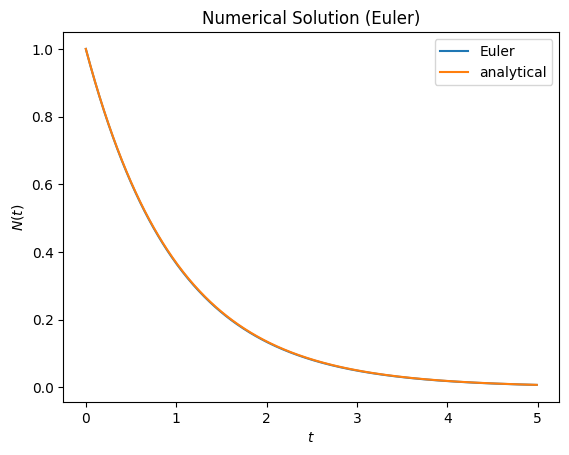

In [3]:
def RadioactiveDecay(
    N_0=1, tau=1, t_max=5, dt = None,
    precision_level = 100,
    visualise = False,
    methods = ["Euler"],
    compute_error = False,
    compute_one_step_error = False
    ):
    def dydt(t,N):return - N / tau
    def N(t):return N_0 * np.exp(-t/tau)
    if dt is None:dt = tau/precision_level
    t,results = Numerical_Solver(
        N_0,dt,0,t_max,dydt,
        methods=methods,
        x_analytical=N, # analytical solution (function). If avaliable, compute errors too
        visualise=visualise, # if True, does some plotting
        variable_name="$N(t)$",
        compute_error=compute_error,
        compute_one_step_error=compute_one_step_error
    )
    return t,results

t,res = RadioactiveDecay(visualise=True)

### Part 2

Now, we need to plot the numerical and exact solutions for several values of $\Delta t$ (`dt` in the code)

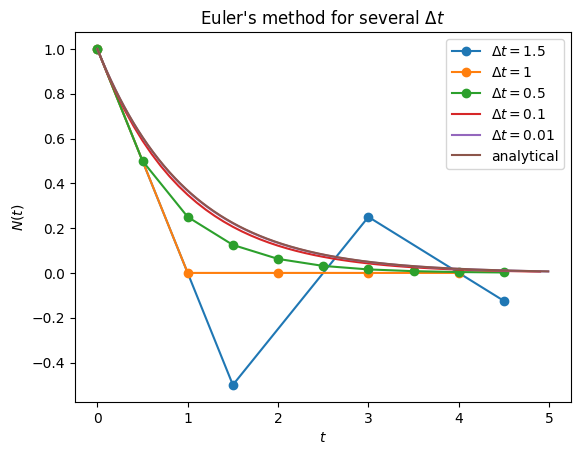

In [4]:
for dt in [0.01,0.1,0.5,1,1.5][::-1]:
    t,res = RadioactiveDecay(
        N_0 = 1,
        tau =1,
        t_max=5,
        dt = dt,
        visualise = False,
        methods=["Euler"]
    )
    ms = '-o' if dt >= 0.5 else '-'
    plt.plot(t,res["Euler"],ms,label=f"$\Delta t={dt}$")
plt.plot(t,res["analytical"],label="analytical")
plt.ylabel("$N(t)$")
plt.xlabel("$t$")
plt.legend()
plt.title("Euler's method for several $\Delta t$")
plt.show()

Looking at the solution only till $t_max = 5$ doesn't give us the full picture. So, let's extend it to 50.

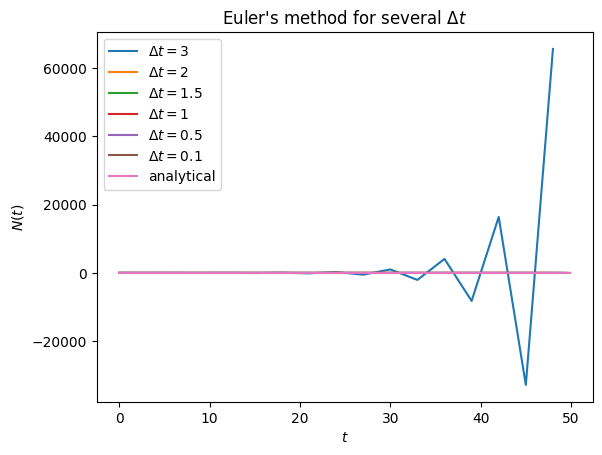

In [5]:
for dt in [0.1,0.5,1,1.5,2,3][::-1]:
    t,res = RadioactiveDecay(
        N_0 = 1,
        tau = 1,
        t_max=50,
        dt = dt,
        visualise = False,
        methods=["Euler"]
    )
    plt.plot(t,res["Euler"],label=f"$\Delta t={dt}$")
plt.plot(t,res["analytical"],label="analytical")
plt.ylabel("$N(t)$")
plt.xlabel("$t$")
plt.legend()
plt.title("Euler's method for several $\Delta t$")
plt.show()

The numeric solution is actually 

$$
N_\text{num}[n] = N_\text{num}(n \Delta t) = N_0 (1-\Delta t/\tau)^n
$$

It's easy to see that when $0 < \Delta t < 2\tau$, we have a decaying solution, namely 

$$
\lim_{n\to \infty} N_\text{num}[n] = 0
$$

Another easy thing to see is that if $\Delta t < \tau$ , then the numeric solution won't have flipping sign. 

To see this in action, let's plot the numerical solutions for $\Delta t$ equal to 0.5, 1.5 and 2.5 and $\tau = 1$.

#### $\Delta t = 0.5$

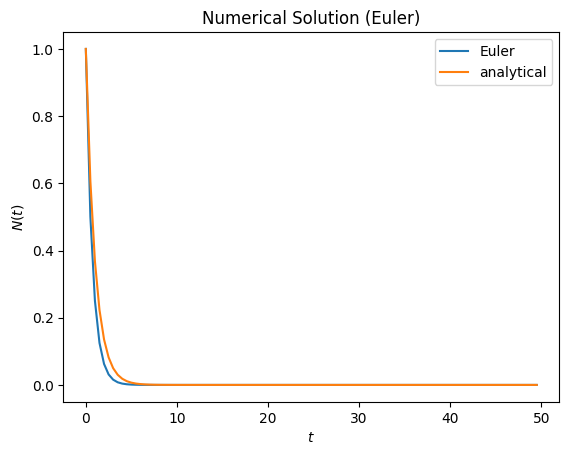

In [6]:
t,res = RadioactiveDecay(
        N_0 = 1,
        tau = 1,
        t_max=50,
        dt = 0.5,
        visualise = True,
        methods=["Euler"]
    )

#### $\Delta t = 1.5$

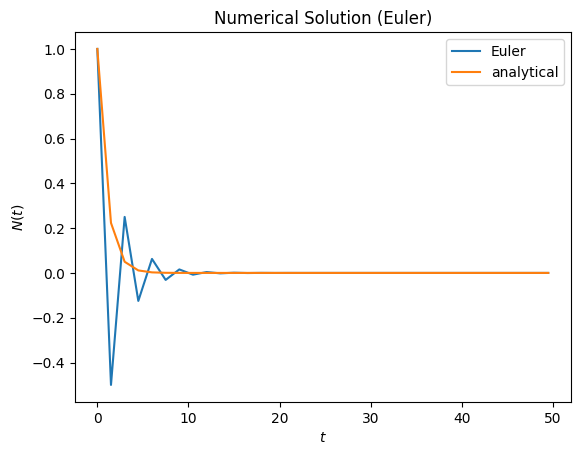

In [7]:
t,res = RadioactiveDecay(
        N_0 = 1,
        tau = 1,
        t_max=50,
        dt = 1.5,
        visualise = True,
        methods=["Euler"]
    )

#### $\Delta t = 2.5$

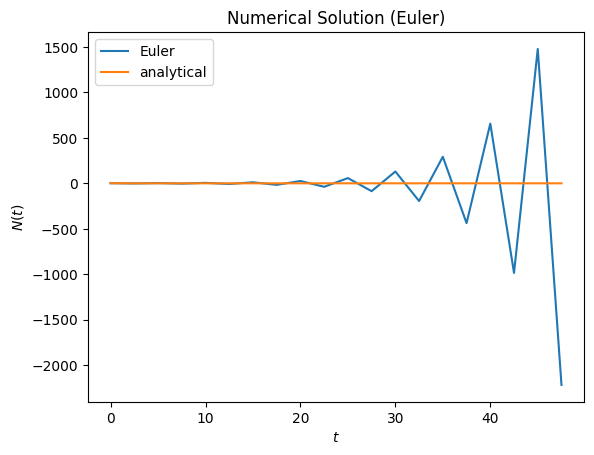

In [8]:
t,res = RadioactiveDecay(
        N_0 = 1,
        tau = 1,
        t_max=50,
        dt = 2.5,
        visualise = True,
        methods=["Euler"]
    )

### Part 3

Now, we need to compare between Euler's method and the RK2 method. First let's only compare for a single $\Delta t$. To be able to see the difference, let's use $\Delta t = 0.5$.

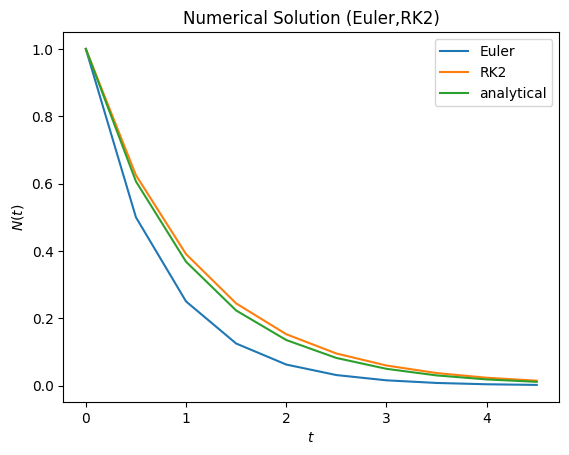

In [9]:
t,res = RadioactiveDecay(
        N_0 = 1,
        tau =1,
        t_max=5,
        dt = 0.5,
        visualise = True,
        methods=["Euler","RK2"]
    )

Now, we need to compare for some more $\Delta t$ values. Rather than putting it all in one plot, I will do it for some specific values only, which will make it easier for us to analyse.

#### $\Delta t = 0.5$

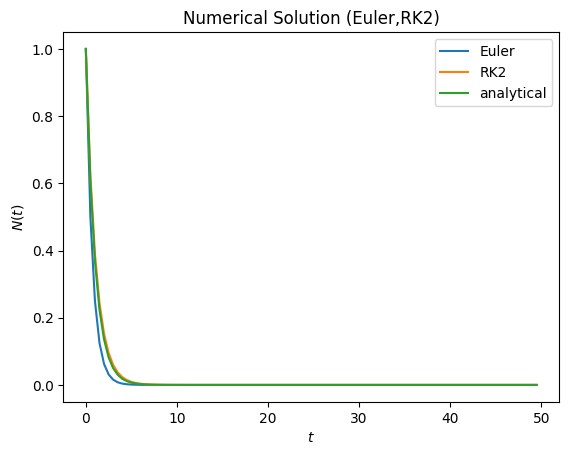

In [10]:
t,res = RadioactiveDecay(
        N_0 = 1,
        tau = 1,
        t_max=50,
        dt = 0.5,
        visualise = True,
        methods=["Euler","RK2"]
    )

#### $\Delta t = 1.5$

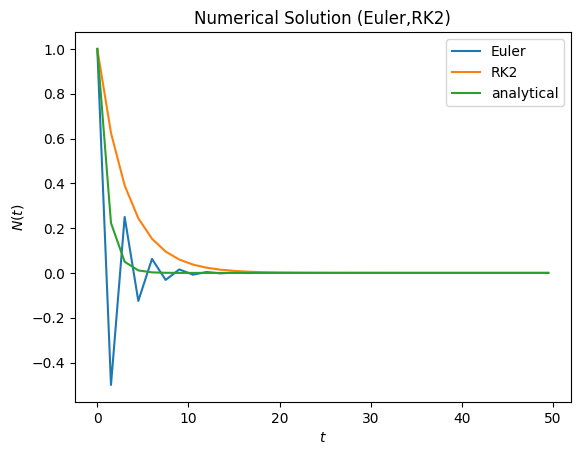

In [11]:
t,res = RadioactiveDecay(
        N_0 = 1,
        tau = 1,
        t_max=50,
        dt = 1.5,
        visualise = True,
        methods=["Euler","RK2"]
    )

#### $\Delta t = 2.5$

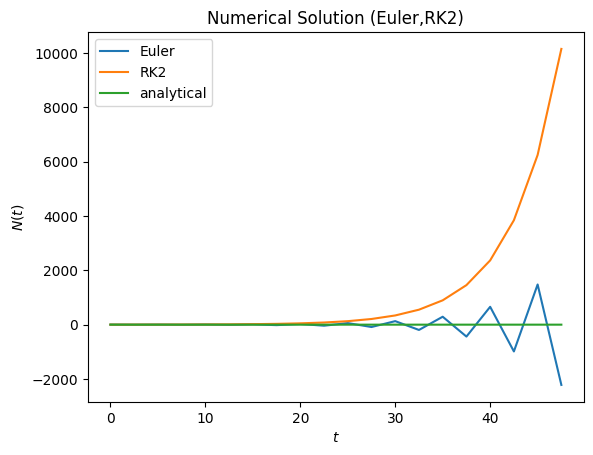

In [12]:
t,res = RadioactiveDecay(
        N_0 = 1,
        tau = 1,
        t_max=50,
        dt = 2.5,
        visualise = True,
        methods=["Euler","RK2"]
    )

### Part 4

Now, we need to plot the error in the final value (at $t_{max}$) computed by Euler and RK2 methods versus the time step $\Delta t$

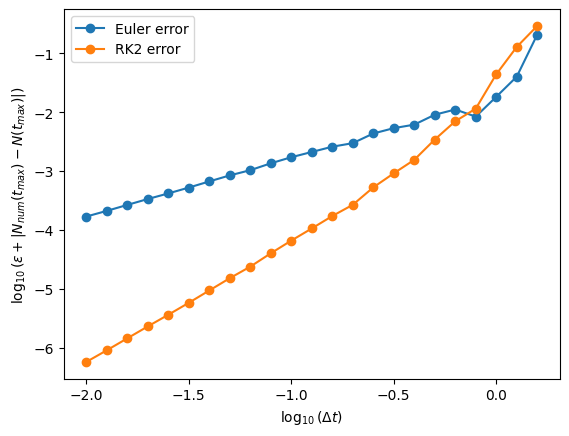

In [13]:
log10dt_list = np.arange(-2,0.3,0.1)
final_err_Euler = []
final_err_RK2 = []
for log10dt in log10dt_list: 
    t,res = RadioactiveDecay(
            N_0 = 1,
            tau = 1,
            t_max=5,
            dt = 10**log10dt,
            visualise = False,
            methods=["Euler","RK2"],
            compute_error = True
        )
    final_err_Euler.append(res["Euler error"][-1])
    final_err_RK2.append(res["RK2 error"][-1])
plt.plot(log10dt_list, np.log10(1e-20+np.abs(final_err_Euler)),'-o', label="Euler error")
plt.plot(log10dt_list, np.log10(1e-20+np.abs(final_err_RK2)),'-o', label="RK2 error")
plt.legend()
plt.xlabel("$\log_{10}(\Delta t)$")
plt.ylabel("$\log_{10}(\epsilon+|N_{num}(t_{max})-N(t_{max})|)$")
plt.show()

As you can see, the error for RK2 method is about twice as low as the Euler error on the log-scale. This is to be expected as the RK2 error in the final value is $O(t_\text{max}\Delta t^2)$ whereas, the Euler error is $O(t_\text{max}\Delta t)$.

### Part 5

The question is, why is it useful to solve a problem numerically even when the exact solution is known? 

There are two reasons I can think of:
1. To verify whether the analytical solution is correct. 
2. If the analytical solution has a very high complexity of calculation (think, having to compute the `exp` function), it might be easier to solve numerically.

### Part 6

Now, we want to compute the "single-step-error", which is the error intriduced by a single step, assuming the value before the step was accurate. 
We want to compare this error for RK2 and Euler's method and see if the error scales as $O(\Delta t^3)$ and $O(\Delta t^2)$ for the methods, respectively. 

First, I will simply plot this error for different $t$ values and a single $\Delta t$ (0.1) . 

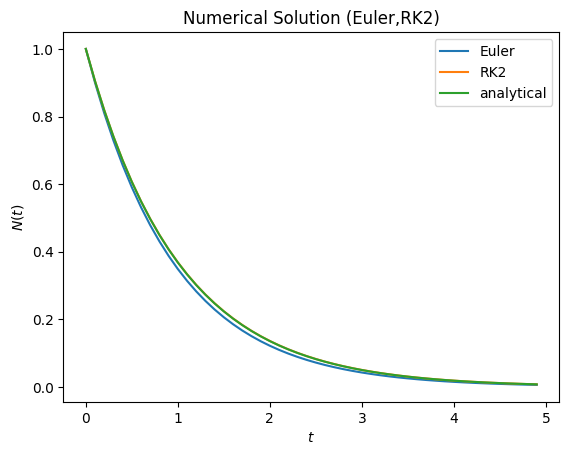

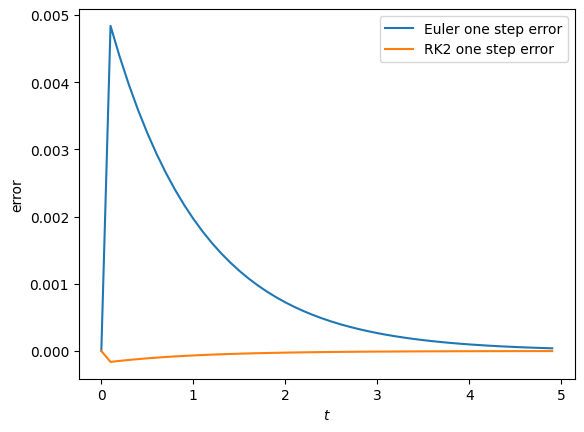

In [14]:
t,res = RadioactiveDecay(
            N_0 = 1,
            tau = 1,
            t_max=5,
            dt = 0.1,
            visualise = True,
            methods=["Euler","RK2"],
            compute_one_step_error = True
        )

Note the the numerical solution is still cmputed using the usual algorithm, with no involvement of the analytical solution. 

As you can see from the second plot, the one step error for RK2 is much lower than the error for Euler's method.

Now, to assess the dependence on $\Delta t$, I waill compute the one time error for steps at $t=0$ only. 
(This is what was given in the lab-sheet). 

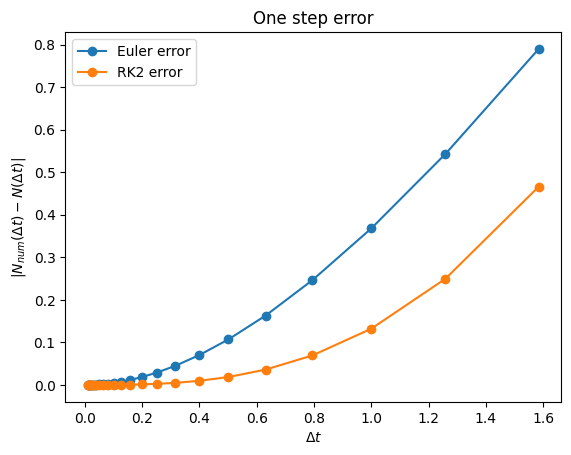

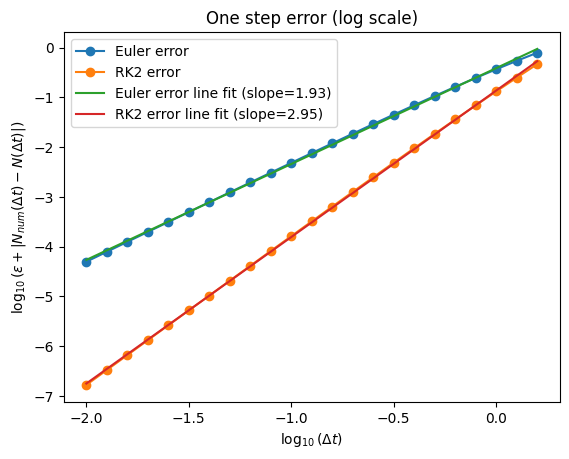

In [15]:
log10dt_list = np.arange(-2,0.3,0.1)
dt_list = 10**log10dt_list
one_step_err_Euler = []
one_step_err_RK2 = []

def dydt(t,N):
    tau =1
    return -N/tau

N_0 = 1
tau = 1

for dt in dt_list: 
    N_dt = N_0 * np.exp(-dt/tau)
    e_E = N_dt - step(i=0,t=[0],x=[N_0],dydt=dydt,method="Euler",dt=dt)
    e_RK2 = N_dt - step(i=0,t=[0],x=[N_0],dydt=dydt,method="RK2",dt=dt)
    one_step_err_Euler.append(e_E)
    one_step_err_RK2.append(e_RK2)

plt.plot(dt_list,np.abs(one_step_err_Euler),'-o', label="Euler error")
plt.plot(dt_list,np.abs(one_step_err_RK2),'-o', label="RK2 error")
plt.xlabel("$\Delta t$")
plt.ylabel("$|N_{num}(\Delta t)-N(\Delta t)|$")
plt.title("One step error")
plt.legend()
plt.figure()
log_scale_err_Euler = np.log10(1e-20+np.abs(one_step_err_Euler))
log_scale_err_RK2 = np.log10(1e-20+np.abs(one_step_err_RK2))
plt.plot(log10dt_list, log_scale_err_Euler,'-o', label="Euler error")
plt.plot(log10dt_list, log_scale_err_RK2,'-o', label="RK2 error")
x_de_trend = (log10dt_list - np.mean(log10dt_list))
var = np.sum(x_de_trend**2)
cov_E = np.sum(x_de_trend * (log_scale_err_Euler - np.mean(log_scale_err_Euler)))
slope_E = cov_E/var
intercept_E = np.mean(log_scale_err_Euler) - slope_E * np.mean(log10dt_list)
cov_RK2 = np.sum(x_de_trend * (log_scale_err_RK2 - np.mean(log_scale_err_RK2)))
slope_RK2 = cov_RK2/var
intercept_RK2 = np.mean(log_scale_err_RK2) - slope_RK2 * np.mean(log10dt_list)
plt.plot(log10dt_list, intercept_E + slope_E*log10dt_list, label=f"Euler error line fit (slope={slope_E:.2f})")
plt.plot(log10dt_list, intercept_RK2 + slope_RK2*log10dt_list, label=f"RK2 error line fit (slope={slope_RK2:.2f})")
plt.legend()
plt.xlabel("$\log_{10}(\Delta t)$")
plt.ylabel("$\log_{10}(\epsilon+|N_{num}(\Delta t)-N(\Delta t)|)$")
plt.title("One step error (log scale)")
plt.show()

In the log-log scale graph, we can clearly see that the slopes for the lines (fit on the one step error data) for Euler and RK2 methods are around 2 and 3 respectively. This is a clear indication of the $O(\Delta^2)$ and $O(\Delta t^3)$ dependences respectively.

### Part 7

This part is just another repetition of the work done during part 4 but with more rigor. Mainly, just like in part 6, we will fit a linear regression to the data generated in the log-log scale to determine the dependence of global (final) error on $\Delta t$

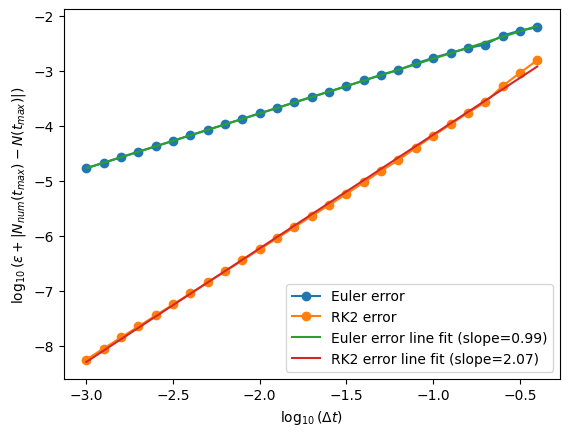

In [16]:
log10dt_list = np.arange(-3,-0.3,0.1) # safer range than in part 4
final_err_Euler = []
final_err_RK2 = []
for log10dt in log10dt_list: 
    t,res = RadioactiveDecay(
            N_0 = 1,
            tau = 1,
            t_max=5,
            dt = 10**log10dt,
            visualise = False,
            methods=["Euler","RK2"],
            compute_error = True
        )
    final_err_Euler.append(res["Euler error"][-1])
    final_err_RK2.append(res["RK2 error"][-1])
log_scale_err_Euler = np.log10(1e-20+np.abs(final_err_Euler))
log_scale_err_RK2 = np.log10(1e-20+np.abs(final_err_RK2))
plt.plot(log10dt_list, log_scale_err_Euler,'-o', label="Euler error")
plt.plot(log10dt_list, log_scale_err_RK2,'-o', label="RK2 error")
x_de_trend = (log10dt_list - np.mean(log10dt_list))
var = np.sum(x_de_trend**2)
cov_E = np.sum(x_de_trend * (log_scale_err_Euler - np.mean(log_scale_err_Euler)))
slope_E = cov_E/var
intercept_E = np.mean(log_scale_err_Euler) - slope_E * np.mean(log10dt_list)
cov_RK2 = np.sum(x_de_trend * (log_scale_err_RK2 - np.mean(log_scale_err_RK2)))
slope_RK2 = cov_RK2/var
intercept_RK2 = np.mean(log_scale_err_RK2) - slope_RK2 * np.mean(log10dt_list)
plt.plot(log10dt_list, intercept_E + slope_E*log10dt_list, label=f"Euler error line fit (slope={slope_E:.2f})")
plt.plot(log10dt_list, intercept_RK2 + slope_RK2*log10dt_list, label=f"RK2 error line fit (slope={slope_RK2:.2f})")
plt.legend()
plt.xlabel("$\log_{10}(\Delta t)$")
plt.ylabel("$\log_{10}(\epsilon+|N_{num}(t_{max})-N(t_{max})|)$")
plt.show()

Thus, the dependnece of global error on $\Delta t$ for Euler and RK2 is $O(\Delta t)$ and $O(\Delta t^2)$ respectively (after rounding the slopes to 1 and 2).

Note that this is only for small $\Delta t$ values. On including larger values, I found deviation from the linear fit in the log-log scale graphs. 

Thus, I won't be saying anything for large $\Delta t$. 

## Problem 2 : Velocity-Dependent Drag

### Part 1

We are given the equation

$$
\frac{dv}{dt}= a-bv \\ \text{where }a=10,\,b=1
$$

and the initial value $v(0)=v_0= 0$.

We know that this can be solved as 

$$
\ln|\frac{a-bv(t)}{a-bv_0}| = -bt \\\implies
a - bv(t) = \pm (a-bv_0) e^{-bt} \\\implies
v(t) = (a/b) \pm ((a/b) - v_0) e^{-bt}
$$

Since we need $v(0)=v_0$, we have the analytical solution 

$$
v(t) = (a/b) - ((a/b) -v_0)e^{-bt}
$$

While we won't rely on it to solve the differential equation, we _will_ use it for comparison.

Since $e^{-t/(1/b)}$ has the time costant $1/b$, that will be our time scale. So, we will use $t_{max} = 5/b = 5$ for the numerical solution.

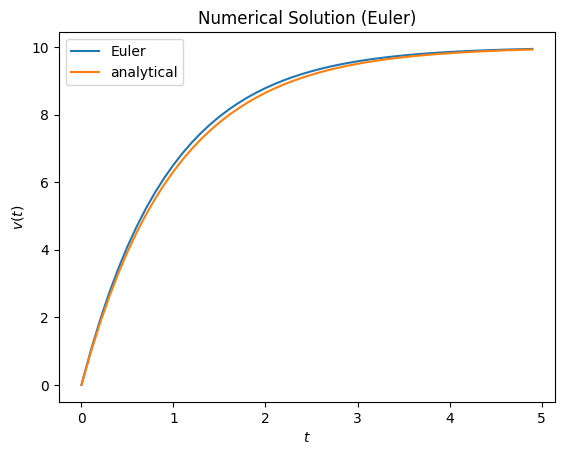

In [17]:
def VelDepDrag(
    v_0=0, a=10, b =1, t_max=5, dt = None,
    precision_level = 100,
    visualise = False,
    methods = ["Euler"],
    compute_error = False,
    compute_one_step_error = False
    ):
    def dydt(t,v):return a- b*v
    def v(t):return (a/b)- ((a/b)-v_0)*np.exp(-b*t)
    if dt is None:dt = (1/b)/precision_level
    t,results = Numerical_Solver(
        v_0,dt,0,t_max,dydt,
        methods=methods,
        x_analytical=v, # analytical solution 
        visualise=visualise,
        variable_name="$v(t)$",
        compute_error=compute_error,
        compute_one_step_error=compute_one_step_error
    )
    return t,results

t,res = VelDepDrag(dt=0.1,visualise=True)

Since we are asked to plot for several $\Delta t$, I will use the values 2,1.5,1,0.5,0.1 and 0.01 . Some of these values lead to oscilatory behaviour. So, I will use $t_{max} =10$.

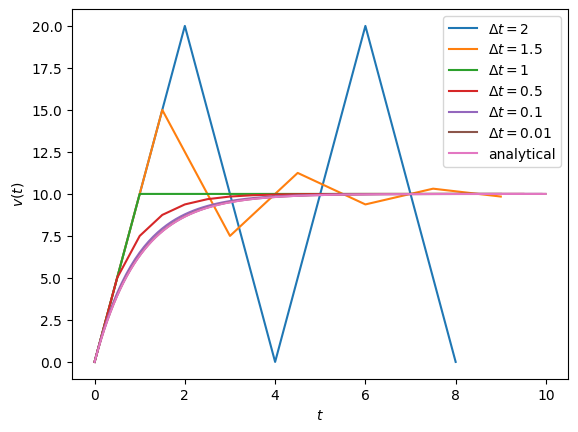

In [18]:
dt_list = [2,1.5,1,0.5,0.1,0.01]
plt.figure()
for dt in dt_list:
    t,res = VelDepDrag(t_max=10,dt=dt,visualise=False)
    plt.plot(t,res["Euler"],label=f"$\Delta t= {dt}$")
plt.plot(t,res["analytical"],label="analytical")
plt.legend()
plt.xlabel("$t$")
plt.ylabel("$v(t)$")
plt.show()

### Part 2

In this part, we need to estimate the terminal velocity, which is $\lim_{t\to\infty} v(t)$ . 

From our analytical solution, it should be $a/b = 10$. This should appear as a horizontal asymptole in the numerical solution. 

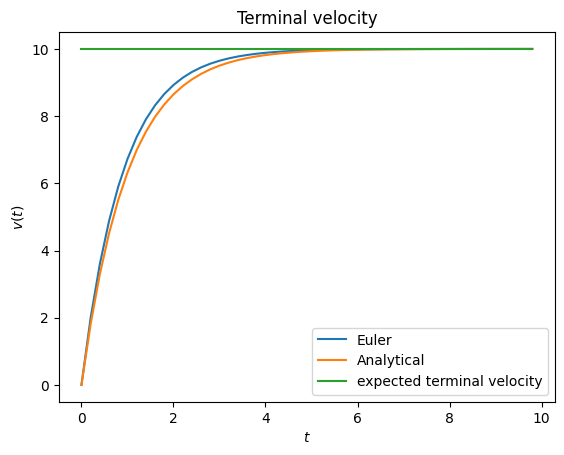

In [19]:
t, res = VelDepDrag(t_max=10, dt=0.2) 
# I am using high dt so that curves are easy to distinguish
plt.plot(t,res["Euler"], label="Euler")
plt.plot(t,res["analytical"], label="Analytical")
plt.plot([t[0],t[-1]], [10,10], label="expected terminal velocity")
plt.legend()
plt.xlabel("$t$")
plt.ylabel("$v(t)$")
plt.title("Terminal velocity")
plt.show()

While I don't know of a proper method for determining the terminal velocity, one could just look at the graph and guess that $v(t)$ stagnates to 10.

### Part 3

There is some ambiguity on which part (1 or 2) we want to repeat with RK2. But I will assume it is part 1. 

For comparing Euler's method and RK2 for several $\Delta t$, I will just create multiple plots, since a single plot will make it harder.

#### $\Delta t = 0.1$

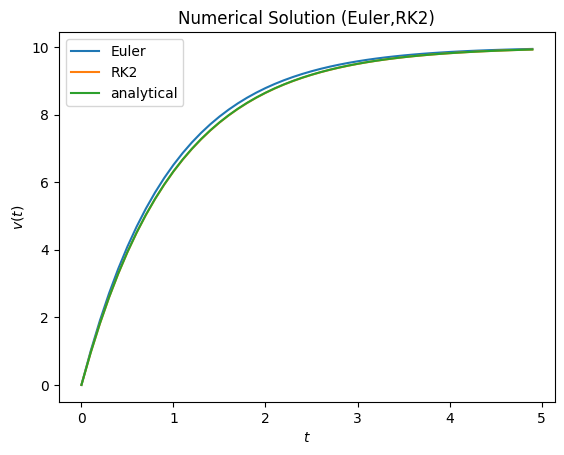

In [20]:
t,res = VelDepDrag(dt=0.1,visualise=True, methods=["Euler","RK2"])

#### $\Delta t = 0.5$

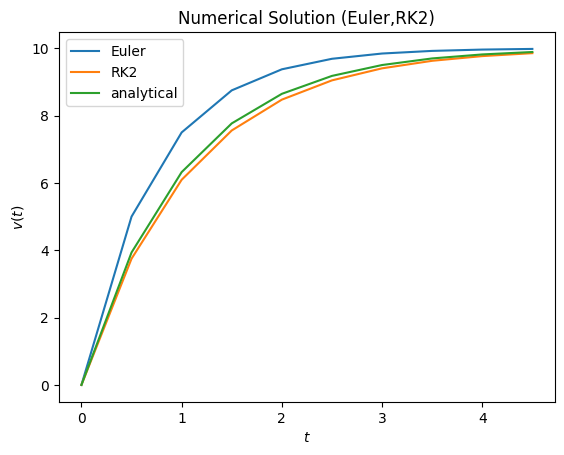

In [21]:
t,res = VelDepDrag(dt=0.5,visualise=True, methods=["Euler","RK2"])

#### $\Delta t = 1$

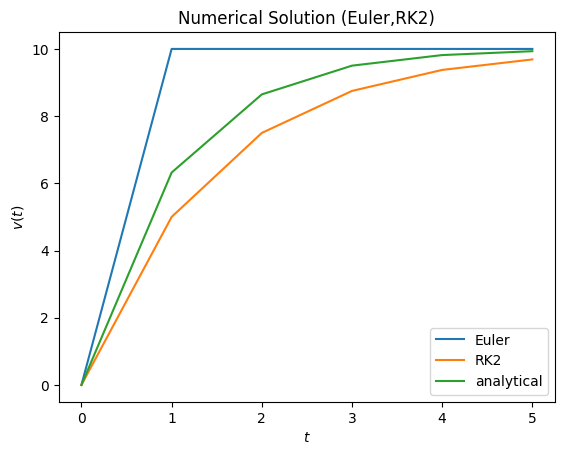

In [22]:
t,res = VelDepDrag(dt=1,t_max=5+1,visualise=True, methods=["Euler","RK2"])

#### Conclusion of comparison

As expected, RK2 gives lower (absolte) errors.

### Part 4

We already saw from the plots in part 1, that we get osciltory motion in the numerical solution from Euler's method when $\Delta t = 1.5$ and at $\Delta t =1$, we don't get the oscilatory motion, but the solution is still inaccurate for small $t$. 

To analyse it in the same manner as we did for Problem 1, we cosider the update equation

$$
v[n] = v(n\Delta t) = v[n-1] + \Delta t (a - bv[n-1]) \\ = (1-b\Delta t)v[n-1] + a\Delta t
$$

Define $p = (1-b\Delta t)$ and $w[n] = p^{-n}v[n]$. Then, we have

$$
w[n] = w[n-1] + a\Delta t p^{-n} \\\implies
w[n] = w[0] + a\Delta t\sum_{i=1}^{n} (p^{-1})^n \\ 
= w[0] + a\Delta t p^{-1} (\frac{1-p^{-n}}{1-p^{-1}}) \\ = w[0] + a\Delta t \frac{(1-p^{-n})}{p-1} \\ \implies
v[n] p^{-n} = v[0] + a\Delta t \frac{(1-p^{-n})}{p-1} \\\implies v[n] = v_0 p^n + a\Delta t \frac{(p^n-1)}{p-1} \\ = v_0 p^n + \frac{a}{b} (1-p^n) \\ 
= (a/b) - ((a/b) - v_0) p^n
$$

It's easy to see that $\lim_{\Delta t\to 0^+} p = e^{-b}$ and so Euler's method is accurate for small $\Delta t$. 

For large $\Delta t$, the numerical solution will stagnate only is $|p| < 1 \iff \Delta t \in (0,2/b) \iff \Delta t < 2/b = 2$. Moreover, the solution will not show oscilatory behaviour only when $p > 1 \iff \Delta t < 1/b = 1$

When we have $p=0 \iff \Delta t =1$, we simply get $v[n] = a/b\,\forall n > 0$, which is also the terminal velocity. 

This is exaclty the behaviour we observed in part 1.

### Part 5

We want to increase $\Delta t$ till we start getting osciltions or divergence in Euler's method based solution. Let's use $\Delta t = 1.5$ for this, which will give us orscilations (but not divergence).
Now, we want to see whether RK2 is able to fix the oscilations.

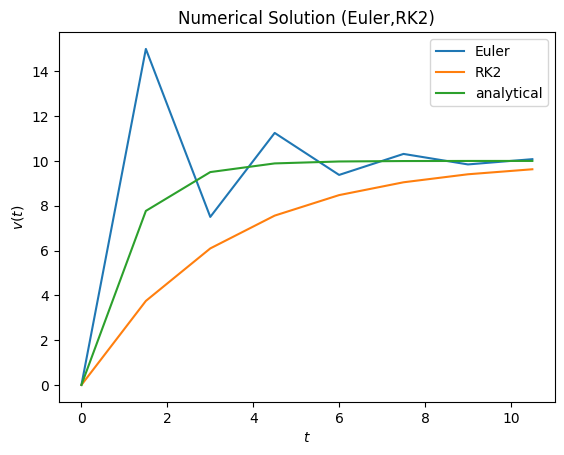

In [23]:
t,res = VelDepDrag(t_max=11,dt=1.5, methods=["Euler","RK2"],visualise=True)

As you can see, this RK2 removed the oscilations. 

Another thing to notice is that although both RK2 and Euler's method are converging to the analytical solution as $t$ increases, Euler's method is showing lower error overall. This is counter-intuitive to what we expect. 

The only time I recall seeing something like this was momentum based gradient descent. And I suspect something similar may be happening here. The oscilatory motion actually speeds up convergence. 

Just to be sure, let's try again, for $\Delta t=1.7$

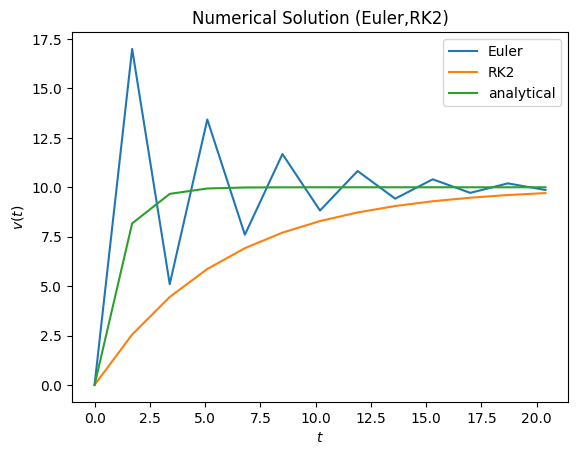

In [24]:
t,res = VelDepDrag(t_max=21,dt=1.7, methods=["Euler","RK2"],visualise=True)

Again, Euler's method is converging faster to the terminal velocity.

## Problem 3: Coupled Radioactive Decay

### Analysis

We are given the equation

$$
\frac{d}{dt} \vec N = \vec f(t,\vec N)
\\ \text{where } \vec N = \begin{bmatrix}N_A\\ N_B\end{bmatrix}
\\ \text{and } \vec f(t,\vec N) = \begin{bmatrix}-N_A/\tau_A\\ \frac{N_A}{\tau_A}- \frac{N_B}{\tau_B}\end{bmatrix} = M \vec N \\\text{where } 
M = \begin{bmatrix} 
-1/\tau_A & 0\\
1/\tau_A & -1/\tau_B
\end{bmatrix}
$$

with the initial value $\vec N_0 = [1\;0]^T$

This formulation is well known in signal processing (in particular, in modern control theory) and has the analytical solution 

$$
\vec N = \exp(Mt)\vec N_0
$$

In particular, if $M$ has the eigenvalue decomposition $M = RDR^{-1}$ where $D = \text{diag}([\lambda_1\;\lambda_2])$ , then we have $\exp(Dt) = \text{diag}([e^{\lambda_1 t}\;e^{\lambda_2 t}])$ and $\exp(Mt) = R \exp(Dt) R^{-1}$. This allows for easy computation. 

Now, let's define $1/\tau_A = k_A$ and $1/\tau_B = k_B$. Then, 

$$
M = \begin{bmatrix}
-k_A & 0\\
k_A & -k_B
\end{bmatrix}
$$

The characteristic equation for $M$ is $(\lambda + k_A)(\lambda - k_B) = 0$. This means that $-k_A, -k_B$ are the eigenvalues. 

From this, we already know that $\vec N$ is of form $\vec N_1 e^{-k_A t} + \vec N_2 e^{-k_B t}$ . 

If instead, we were to use Euler's method, we would have

$$
\vec N[n] = (I - M\Delta t) \vec N[n-1] \implies 
\vec N = (I - M\Delta t)^n N[n-1]
$$

Again, we can use eigen-value decomposition of $(I - M\Delta t)$ to comment about boundedness and non-oscilatory motion of the solution from Euler's method. In particular, if both eigen-values have magnitude smaller than 1, then we'll have a decaying, $\vec N[n]$. If the eigenvalues are both non-negative, then we'll have a non-oscialtory $\vec N[n]$.

Now, to get the analytical solution, we first solve the first differential equation to get 

$$
N_A = e^{-k_A t}
$$

and then plug it in the second one to get :

$$
\frac{d}{dt} N_B = k_A e^{-k_A t} - k_B N_B\\\implies
\frac{d}{dt}(e^{k_B t}N_B) = k_B e^{(k_B-k_A) t} \\\implies 

e^{k_B t}N_B = \frac{k_A}{(k_B-k_A)} (e^{(k_B-k_A) t} - 1) \\\implies
N_B = \frac{k_A}{(k_B-k_A)} (e^{-k_A t} - e^{-k_B t})
$$

Thus, the analytical solution is :

$$
N_A = e^{-t/\tau_A} \\
N_B = \frac{k_A}{(k_B-k_A)}(e^{-t/\tau_A} - e^{-t/\tau_B})
$$



### Parts 1,2,3

In [22]:
def CoupledRadioactiveDecay(
    tau_A=1, tau_B=2, N_A_0=1, N_B_0=0,
    t_max=5, dt = None,
    precision_level = 100,
    methods = ["Euler"],
    compute_error = False,
    compute_one_step_error = False,
    visualise=False
    ):
    def dydt(t,N):
        N_A,N_B = N[0],N[1]
        return np.array([
            -N_A/tau_A,
            N_A/tau_A - N_B/tau_B
            ])
    def N(t):
        assert (not isinstance(t,np.ndarray)) or (t.shape == (1,))
        return np.array([
            np.exp(-t/tau_A),
            (np.exp(-t/tau_A) -np.exp(-t/tau_B))/((tau_A/tau_B)-1)
        ])
    if dt is None:dt = min(tau_A,tau_B)/precision_level
    return Numerical_Solver(
        np.array([N_A_0,N_B_0]),dt,0,t_max,dydt,
        methods=methods,
        x_analytical=N, # analytical solution 
        visualise=("PS" if visualise else False),
        variable_name="$N(t)$",
        compute_error=compute_error,
        compute_one_step_error=compute_one_step_error
    )

In [23]:
def CoupledRadDec_for_tau_B(tau_B=2):
    t,res,ani = CoupledRadioactiveDecay(dt=0.05, tau_A=1, tau_B =tau_B, visualise=True)
    N_A_num = res["Euler"][:,0]
    N_A = res["analytical"][:,0]
    N_B_num = res["Euler"][:,1]
    N_B = res["analytical"][:,1]
    plt.figure()
    plt.subplot(2,1,1)
    plt.plot(t,N_A_num,label="Numeric (Euler)"),
    plt.plot(t,N_A,label="Analytic")
    plt.legend()
    plt.ylabel("$N_A(t)$")
    plt.title(r"$\tau_B=" + f"{tau_B:.2f}" + "$")
    plt.subplot(2,1,2)
    plt.plot(t,N_B_num,label="Numeric (Euler)"),
    plt.plot(t,N_B,label="Analytic")
    plt.legend()
    plt.ylabel("$N_B(t)$")
    plt.xlabel("$t$")
    plt.show()
    return ani

#### $\tau_B = 100 \gg \tau_A =1$

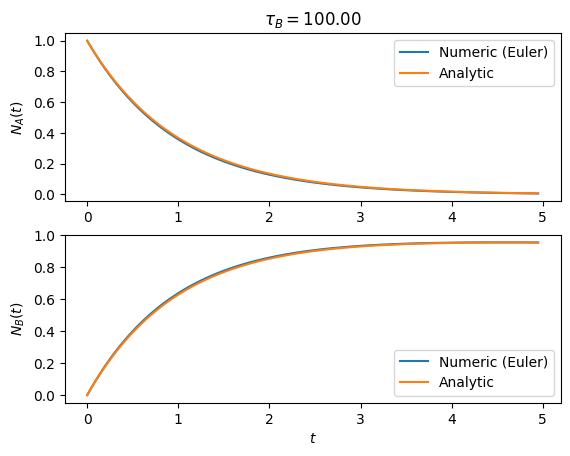

In [24]:
ani = CoupledRadDec_for_tau_B(100)

In [25]:
ani

#### $\tau_B = 2 \sim \tau_A = 1$

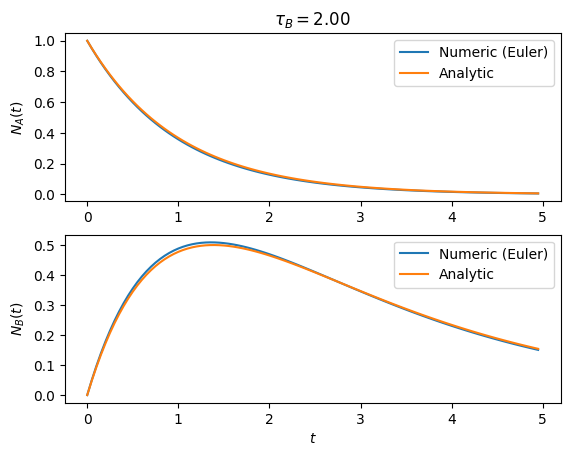

In [28]:
CoupledRadDec_for_tau_B(2)

#### $\tau_B = 0.05 \ll \tau_A =1$

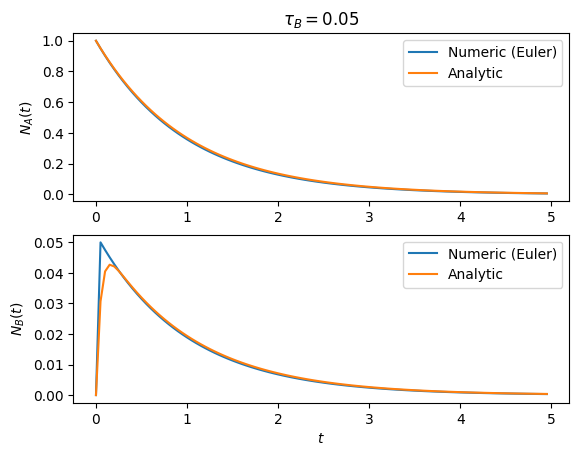

In [29]:
CoupledRadDec_for_tau_B(0.05)

#### $\tau_B = 0.03 \ll \tau_A$

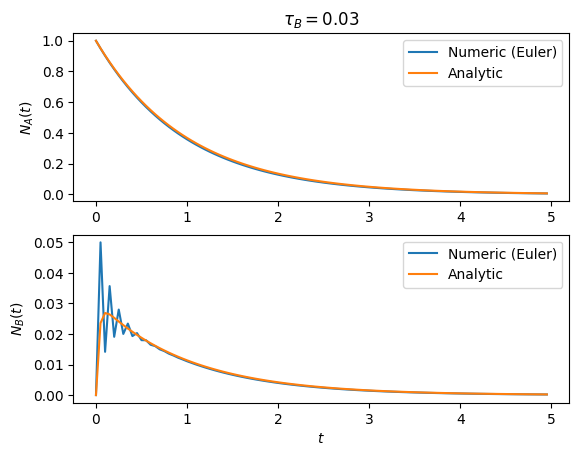

In [30]:
CoupledRadDec_for_tau_B(0.03)

#### Conclusion

As expected, changing $\tau_A$ doesn't change anything for $N_A$ while the curve for $N_B$ changes. 

We also see the peak of the $N_B$ curve move to the left (earlier in time) as $\tau_B$ is decreased. 

Moreover, the analytical and numeric solutions are close to each other when $\tau_B \gg \tau_A$ but when $\tau_B \ll \tau_A =1$, we start to observe oscilatory motion, which is to be expected since now $\Delta t$ is not adequate for the new (smaller) time scale $\min(\tau_A,\tau_B) = \tau_B$. 

### Part 4,5

For our comparison between Euler's method and RK2, I will use $\Delta t = 0.07$ and $\tau_B = 0.03, \;\tau_A = 1$.  

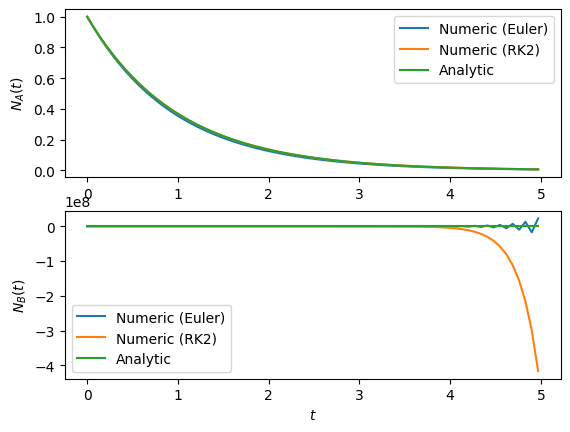

In [31]:
t,res = CoupledRadioactiveDecay(
    dt=0.07, tau_A=1, tau_B =0.03,
    methods=["Euler","RK2"])
N_A_E = res["Euler"][:,0]
N_A_RK2 = res["RK2"][:,0]
N_A = res["analytical"][:,0]
N_B_E = res["Euler"][:,1]
N_B_RK2 = res["RK2"][:,1]
N_B = res["analytical"][:,1]
plt.figure()
plt.subplot(2,1,1)
plt.plot(t,N_A_E,label="Numeric (Euler)")
plt.plot(t,N_A_RK2,label="Numeric (RK2)")
plt.plot(t,N_A,label="Analytic")
plt.legend()
plt.ylabel("$N_A(t)$")
plt.subplot(2,1,2)
plt.plot(t,N_B_E,label="Numeric (Euler)")
plt.plot(t,N_B_RK2,label="Numeric (RK2)")
plt.plot(t,N_B,label="Analytic")
plt.legend()
plt.ylabel("$N_B(t)$")
plt.xlabel("$t$")
plt.show()

As you can see, Euler's method captures the qualitative behaviour better in this case.

Although, one could say that neither capture the behaviour correctly.

But if we change to $\Delta t=0.05$, this changes.

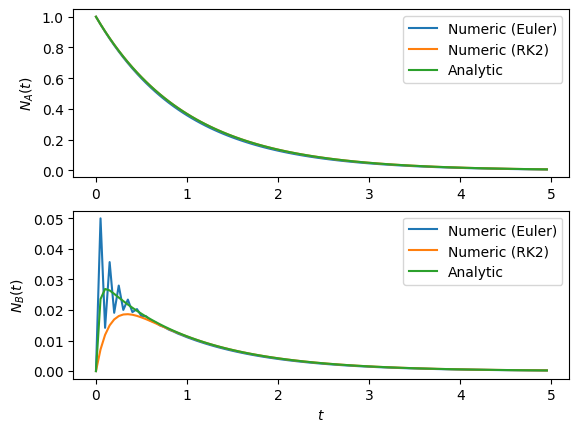

In [32]:
t,res = CoupledRadioactiveDecay(
    dt=0.05, tau_A=1, tau_B =0.03,
    methods=["Euler","RK2"])
N_A_E = res["Euler"][:,0]
N_A_RK2 = res["RK2"][:,0]
N_A = res["analytical"][:,0]
N_B_E = res["Euler"][:,1]
N_B_RK2 = res["RK2"][:,1]
N_B = res["analytical"][:,1]
plt.figure()
plt.subplot(2,1,1)
plt.plot(t,N_A_E,label="Numeric (Euler)")
plt.plot(t,N_A_RK2,label="Numeric (RK2)")
plt.plot(t,N_A,label="Analytic")
plt.legend()
plt.ylabel("$N_A(t)$")
plt.subplot(2,1,2)
plt.plot(t,N_B_E,label="Numeric (Euler)")
plt.plot(t,N_B_RK2,label="Numeric (RK2)")
plt.plot(t,N_B,label="Analytic")
plt.legend()
plt.ylabel("$N_B(t)$")
plt.xlabel("$t$")
plt.show()

Now, the qualitative behaviour (increase, then decrease in $N_B$) is captured better by RK2.

From the graphs, we now know that only $N_B$ shows erratic behaviour for large $\Delta t$ when $\tau_B \ll \tau_A$ and $N_A$ doesn't.

## Problem 4: Nonlinear Population Growth

We are given the equation

$$
\frac{d}{dt}N = aN - bN^2
$$

This can be solved analytically using separation of variables and partial fraction decomposition. 

The final solution after all that is

$$
N(t) = \frac{a}{b + (\frac{a}{N_0}-b)e^{-at}}
$$

In [33]:
def NonLinPopGrowth(
    N_0=1, a=1, b=0, 
    t_max=5, dt = None,
    precision_level = 100,
    visualise = True,
    methods = ["Euler"],
    compute_error = False,
    compute_one_step_error = False
    ):
    def dydt(t,N):return a*N- b*N*N
    def N(t):
        if (b==0): return np.exp(a*t)
        return a/(b + ((a/N_0)-b)*np.exp(-a*t))
    if dt is None:dt = (1/b)/precision_level
    t,results = Numerical_Solver(
        N_0,dt,0,t_max,dydt,
        methods=methods,
        x_analytical=N, # analytical solution 
        visualise=visualise,
        variable_name="$N(t)$",
        compute_error=compute_error,
        compute_one_step_error=compute_one_step_error
    )
    return t,results

### Part 1,2

#### $a=1,b=0,N_0=1$

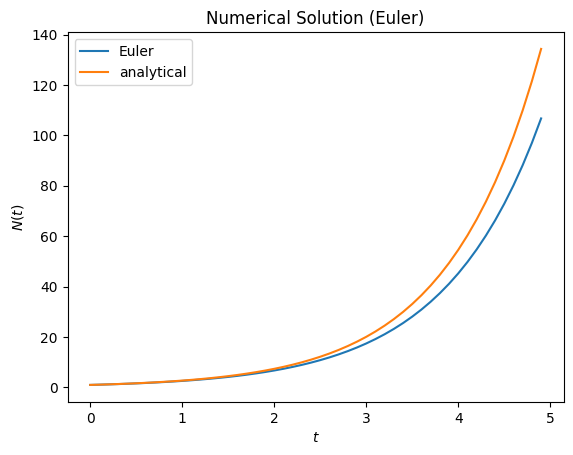

In [34]:
t,res = NonLinPopGrowth(dt=0.1)

#### $a=10,b=3,N_0=1$

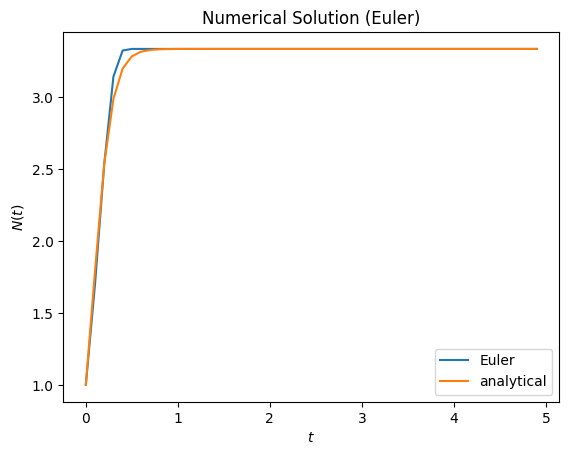

In [35]:
t,res = NonLinPopGrowth(a=10,b=3,N_0=1,dt=0.1)

#### $a=10,b=0.01,N_0=1000$

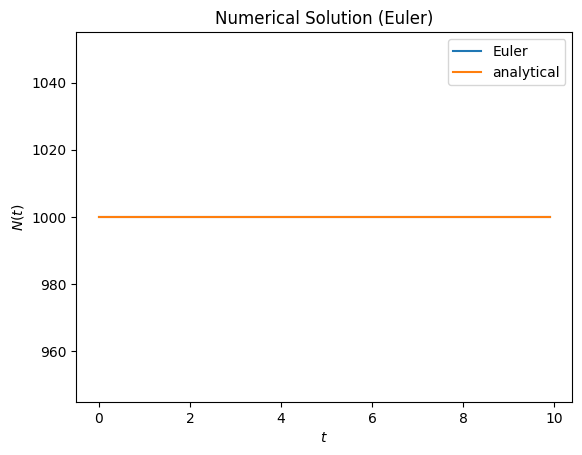

In [36]:
t,res = NonLinPopGrowth(t_max=10,a=10,b=0.01,N_0=1000,dt=0.1)

### Part 4

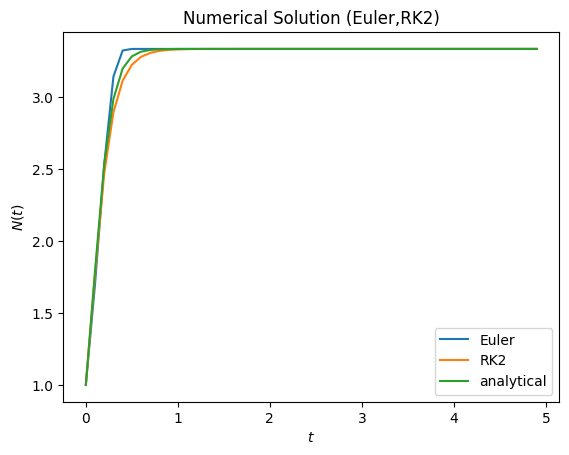

In [37]:
t,res = NonLinPopGrowth(a=10,b=3,N_0=1,dt=0.1,
methods=["Euler","RK2"])

Again, RK2 is better (gives less error).

### Part 3

A steady state $N_s$ will have $\frac{d}{dt}N|_{N_s}=0$ . This, means $aN-bN^2 = 0$ This can happen at $N_s=0$ and at $N_s=a/b$.
The first one is too trivial to verify. 
Let's verify the second one with $a=10,b=5$, giving $N_s=2$ as the steady state, which we'll put as the initial value. 

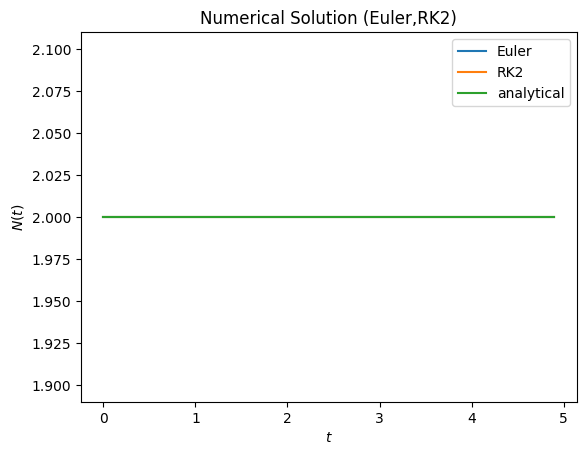

In [38]:
t,res = NonLinPopGrowth(a=10,b=5,N_0=2,dt=0.1,
methods=["Euler","RK2"])

Similarly, if $a=10$ and $b=0.01$, then $N_0 =1000$ is a steady state value, as we saw in part 2.

### Part 5

We need to find $\Delta t$ for which Euler's method will fail. This can happen when $\Delta t \not\ll 1/a$. I will use the case with $a=10, b=3, N_0 = 1$. Thus, $1/a=0.1$ So, let's choose $\Delta t = 0.2$ (this came from hit and trial).

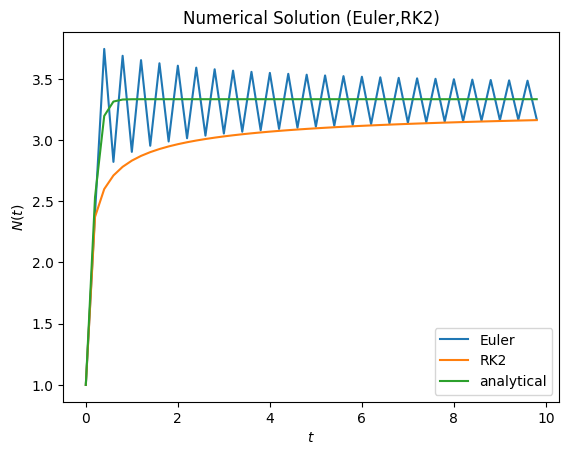

In [39]:
t,res = NonLinPopGrowth(t_max=10,a=10,b=3,N_0=1,dt=0.2,methods=["Euler","RK2"])

Using $\Delta t=0.3018$ causes oscilations in RK2 too.

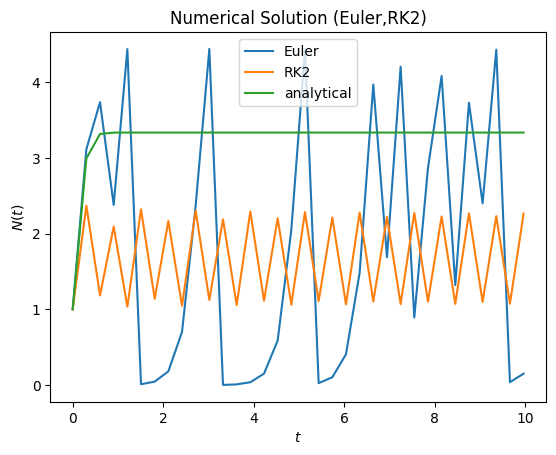

In [40]:
t,res = NonLinPopGrowth(t_max=10,a=10,b=3,N_0=1,dt=0.3018,methods=["Euler","RK2"])

Using a slightly higher time step leads to unbounded solution from Euler's method.

/tmp/ipykernel_109254/1059142424.py:10: RuntimeWarning: overflow encountered in scalar multiply
  def dydt(t,N):return a*N- b*N*N


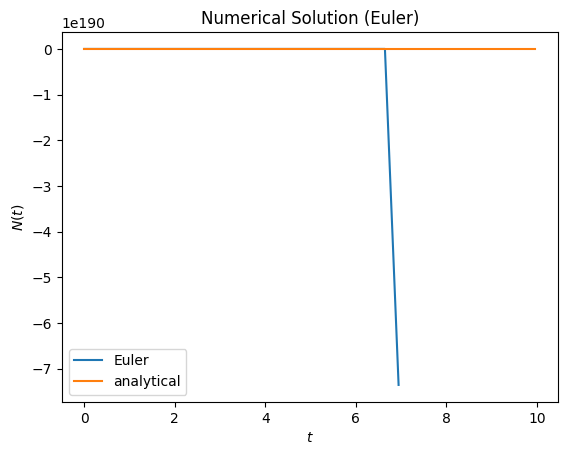

In [41]:
t,res = NonLinPopGrowth(t_max=10,a=10,b=3,N_0=1,dt=0.3019,methods=["Euler"])

Using RK2, we only get oscilations and not unboundedness.

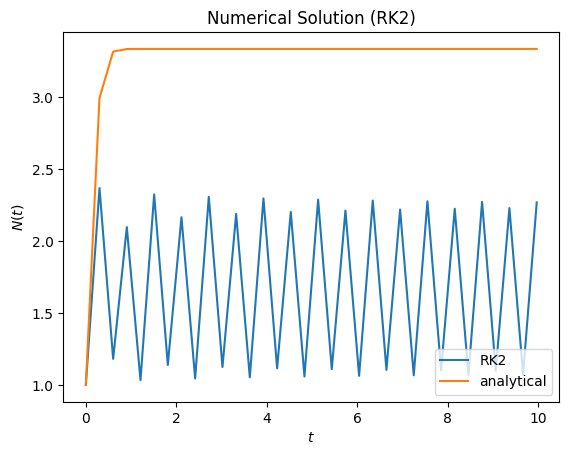

In [42]:
t,res = NonLinPopGrowth(t_max=10,a=10,b=3,N_0=1,dt=0.3019,methods=["RK2"])

### Part 6

For differential equations where the derivative is a linear function of the variable, we can write the solution from Euler's method as a geometric series (in index $n=t/\Delta t$). We also showed (in the class for Jan 13) that the RK2 method also gives a geometric series, but with a positive ratio of form $(1-p+p^2/2)$ where $p=\Delta t/\tau$ which will never lead to oscilating solution.

But with the nonlinear term, RK2 _does_ show oscilatory motion. 

If the question is interpreted in a different way, namely the effect of the nonlinear term on the analytical solution, then, we have non-zero steady states for this case, wheras we didn't for the linear case. But I don't believe this is related to long-time behaviour (since both cases have stagnating or exploding solutions). 